In [1]:
import contextily as cx
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN
from ipywidgets import interact, fixed
import pysal

In [2]:
tokyo = pd.read_csv("https://geographicdata.science/book/_downloads/7fb86b605af15b3c9cbd9bfcbead23e9/tokyo_clean.csv")

In [3]:
tokyo.head()

,user_id,longitude,latitude,date_taken,photo/video_page_url,x,y
0,10727420@N00,139.700499,35.674000,2010-04-09 17:26:25.0,http://www.flickr.com/photos/10727420@N00/4545...,1.555139e+07,4.255856e+06
1,8819274@N04,139.766521,35.709095,2007-02-10 16:08:40.0,http://www.flickr.com/photos/8819274@N04/26503...,1.555874e+07,4.260667e+06
2,62068690@N00,139.765632,35.694482,2008-12-21 15:45:31.0,http://www.flickr.com/photos/62068690@N00/3125...,1.555864e+07,4.258664e+06
3,49503094041@N01,139.784391,35.548589,2011-11-11 05:48:54.0,http://www.flickr.com/photos/49503094041@N01/6...,1.556073e+07,4.238684e+06
4,40443199@N00,139.768753,35.671521,2006-04-06 16:42:49.0,http://www.flickr.com/photos/40443199@N00/2482...,1.555899e+07,4.255517e+06


In [4]:
areas = gpd.read_file("https://darribas.org/gds_course/content/data/tokyo_admin_boundaries.geojson")

In [6]:
areas.head()

,GID_1,NAME_1,GID_2,NAME_2,ENGTYPE_2,geometry
0,JPN.4_1,Chiba,JPN.4.10_1,Ichikawa,City,"MULTIPOLYGON (((139.97650 35.68272, 139.97583 ..."
1,JPN.4_1,Chiba,JPN.4.25_1,Matsudo,City,"MULTIPOLYGON (((139.97223 35.76775, 139.97018 ..."
2,JPN.19_1,Kanagawa,JPN.19.14_1,Kawasaki,City,"MULTIPOLYGON (((139.74057 35.54160, 139.74110 ..."
3,JPN.19_1,Kanagawa,JPN.19.29_1,Yokohama,City,"MULTIPOLYGON (((139.62944 35.40111, 139.62917 ..."
4,JPN.35_1,Saitama,JPN.35.2_1,Asaka,City,"MULTIPOLYGON (((139.62227 35.81256, 139.62088 ..."


In [7]:
tokyo_gdf = gpd.GeoDataFrame(
    {
        "geometry": gpd.points_from_xy(
            tokyo["longitude"], tokyo["latitude"]
        )
    }, crs="EPSG:4326"
).join(tokyo)
crosswalk = gpd.sjoin(tokyo_gdf, areas, how="inner")
tokyo["admin_area"] = crosswalk["GID_2"]

In [10]:
tokyo.head()

,user_id,longitude,latitude,date_taken,photo/video_page_url,x,y,admin_area
0,10727420@N00,139.700499,35.674000,2010-04-09 17:26:25.0,http://www.flickr.com/photos/10727420@N00/4545...,1.555139e+07,4.255856e+06,JPN.41.45_1
1,8819274@N04,139.766521,35.709095,2007-02-10 16:08:40.0,http://www.flickr.com/photos/8819274@N04/26503...,1.555874e+07,4.260667e+06,JPN.41.5_1
2,62068690@N00,139.765632,35.694482,2008-12-21 15:45:31.0,http://www.flickr.com/photos/62068690@N00/3125...,1.555864e+07,4.258664e+06,JPN.41.6_1
3,49503094041@N01,139.784391,35.548589,2011-11-11 05:48:54.0,http://www.flickr.com/photos/49503094041@N01/6...,1.556073e+07,4.238684e+06,JPN.41.43_1
4,40443199@N00,139.768753,35.671521,2006-04-06 16:42:49.0,http://www.flickr.com/photos/40443199@N00/2482...,1.555899e+07,4.255517e+06,JPN.41.8_1


<Axes: xlabel='longitude', ylabel='latitude'>

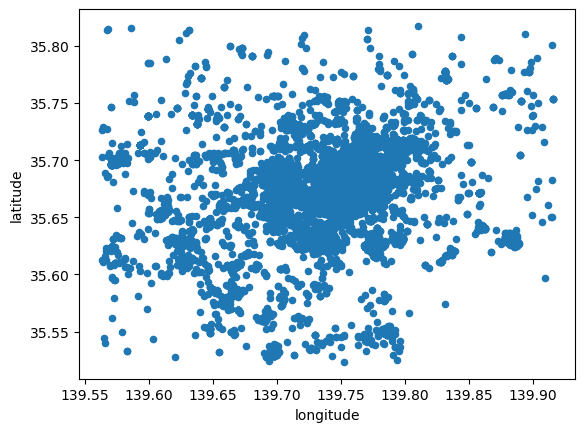

In [12]:
tokyo.plot.scatter("longitude", "latitude")

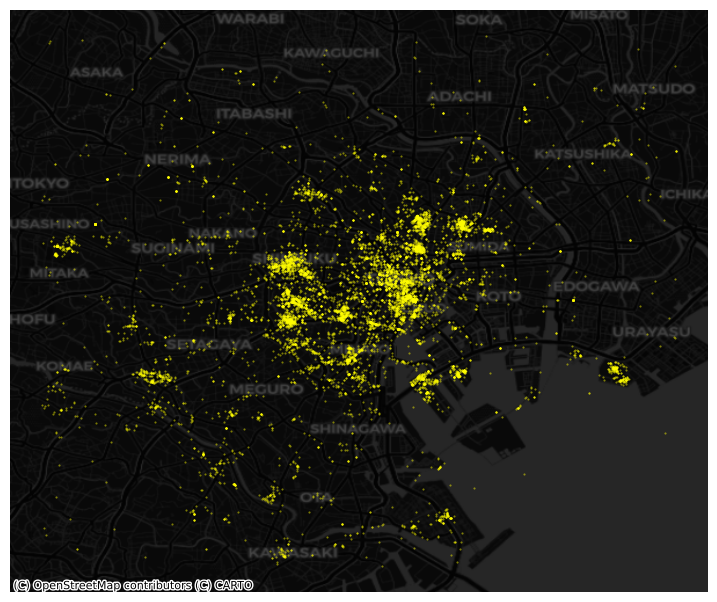

In [13]:
# Plot photographs with smaller, more translucent dots
ax = tokyo.plot.scatter(
    "longitude", 
    "latitude",
    s=0.25,
    c="xkcd:bright yellow",
    alpha=0.5,
    figsize=(9, 9)
)
# remove axis
ax.set_axis_off()
# Add dark basemap
cx.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatter
)

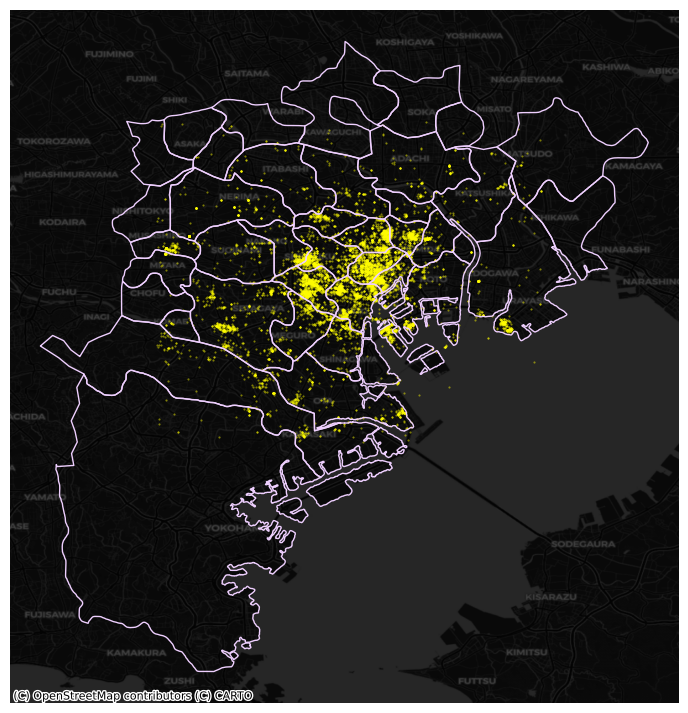

In [15]:
# Plot photographs with smaller, more translucent dots
ax = tokyo.plot.scatter(
    "longitude", 
    "latitude",
    s=0.25,
    c="xkcd:bright yellow",
    alpha=0.5,
    figsize=(9, 9)
)
# Add administrative boundaries
areas.plot(
    ax=ax,
    facecolor="none",
    edgecolor="xkcd:pale lavender"
)
# remove axis
ax.set_axis_off()
# Add dark basemap
cx.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatter
)

In [16]:
# Create counts
photos_by_area = tokyo.groupby("admin_area").size()
# Assign counts into a table of its own 
# and joins it to the areas table
areas = areas.join(
    pd.DataFrame({"photo_count": photos_by_area}),
    on="GID_2"
)

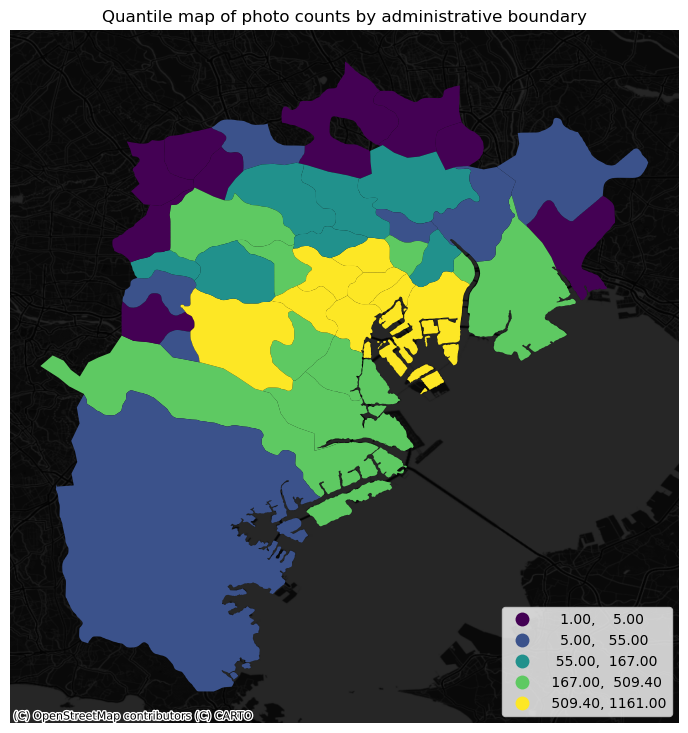

In [17]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot the equal interval choropleth and add a legend
areas.plot(
    column='photo_count', 
    scheme='quantiles', 
    ax=ax,
    legend=True,
    legend_kwds={"loc": 4}
)
# Remove the axes
ax.set_axis_off()
# Set the title
ax.set_title("Quantile map of photo counts by administrative boundary")
# Add dark basemap
cx.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatterNoLabels
)
# Draw map
plt.show()

In [18]:
areas["area_sqm"] = areas.to_crs(epsg=2459).area * 1e-6

In [19]:
areas["photo_density"] = areas["photo_count"] / areas["area_sqm"]

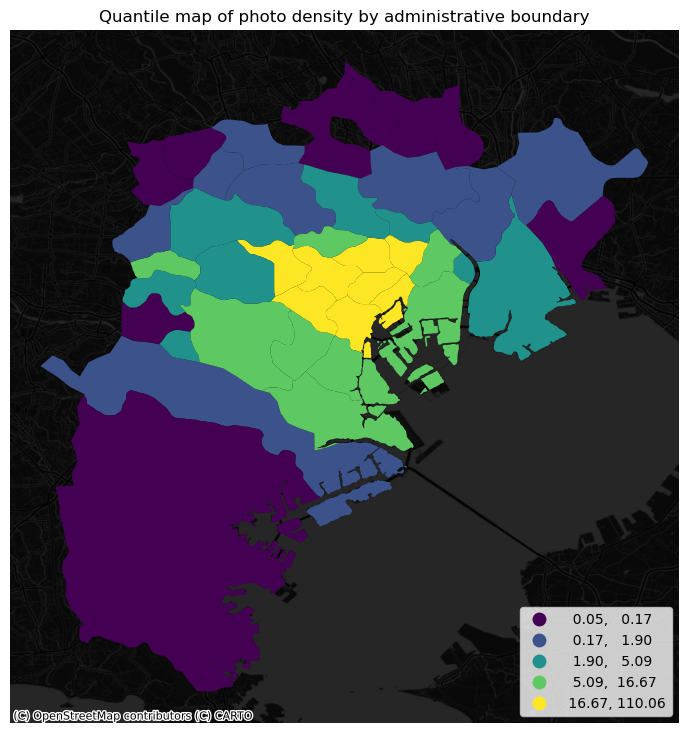

In [20]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot the equal interval choropleth and add a legend
areas.plot(
    column='photo_density', 
    scheme='quantiles', 
    ax=ax,
    legend=True,
    legend_kwds={"loc": 4}
)
# Remove the axes
ax.set_axis_off()
# Set the title
ax.set_title("Quantile map of photo density by administrative boundary")
# Add dark basemap
cx.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatterNoLabels
)
# Draw map
plt.show()

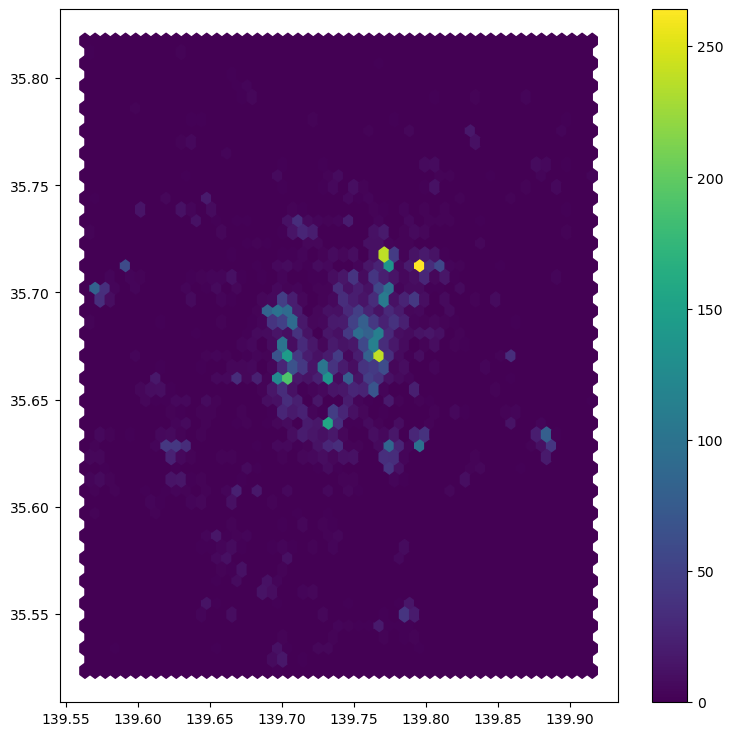

In [21]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add hexagon layer that displays count of points in each polygon
hb = ax.hexbin(
    tokyo["longitude"], 
    tokyo["latitude"], 
    gridsize=50, 
)
# Add a colorbar (optional)
plt.colorbar(hb)

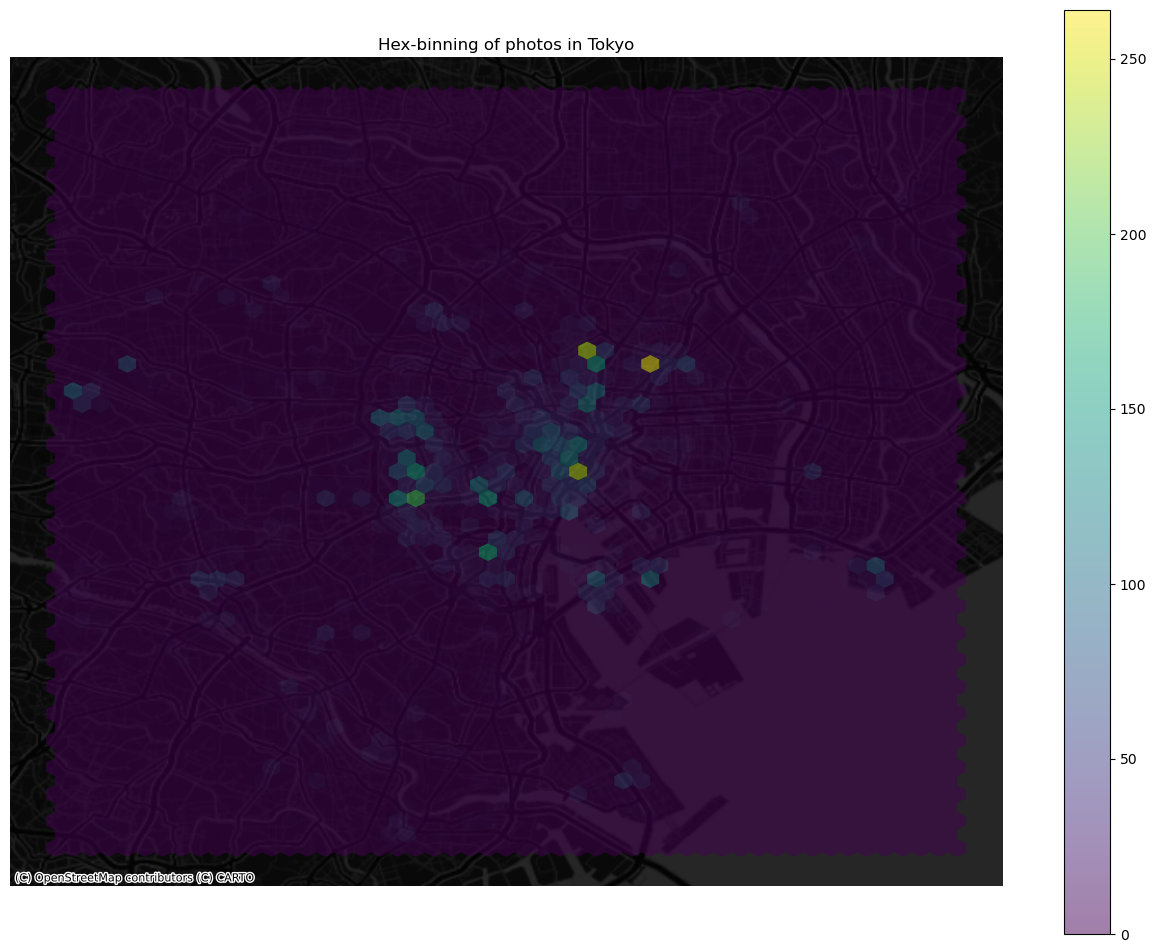

In [22]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(16, 12))
# Add hexagon layer that displays count of points in each polygon
hb = ax.hexbin(
    tokyo["longitude"], 
    tokyo["latitude"], 
    gridsize=50,
    alpha=0.5,
    edgecolor="none"
)
# Add a colorbar (optional)
plt.colorbar(hb)
# Remove axis
ax.set_axis_off()
# Add basemap
cx.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatterNoLabels
)
# Add title of the map
ax.set_title("Hex-binning of photos in Tokyo")
# Draw map
plt.show()

In [23]:
# Take a random subset of 1,000 rows from `tokyo`
tokyo_sub = tokyo.sample(1000, random_state=12345)


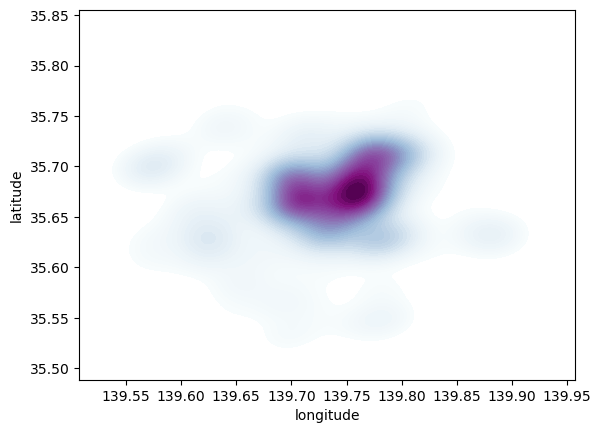

In [24]:
sns.kdeplot(
    x="longitude", 
    y="latitude",
    data=tokyo_sub,
    n_levels=50, 
    fill=True, 
    cmap='BuPu'
);

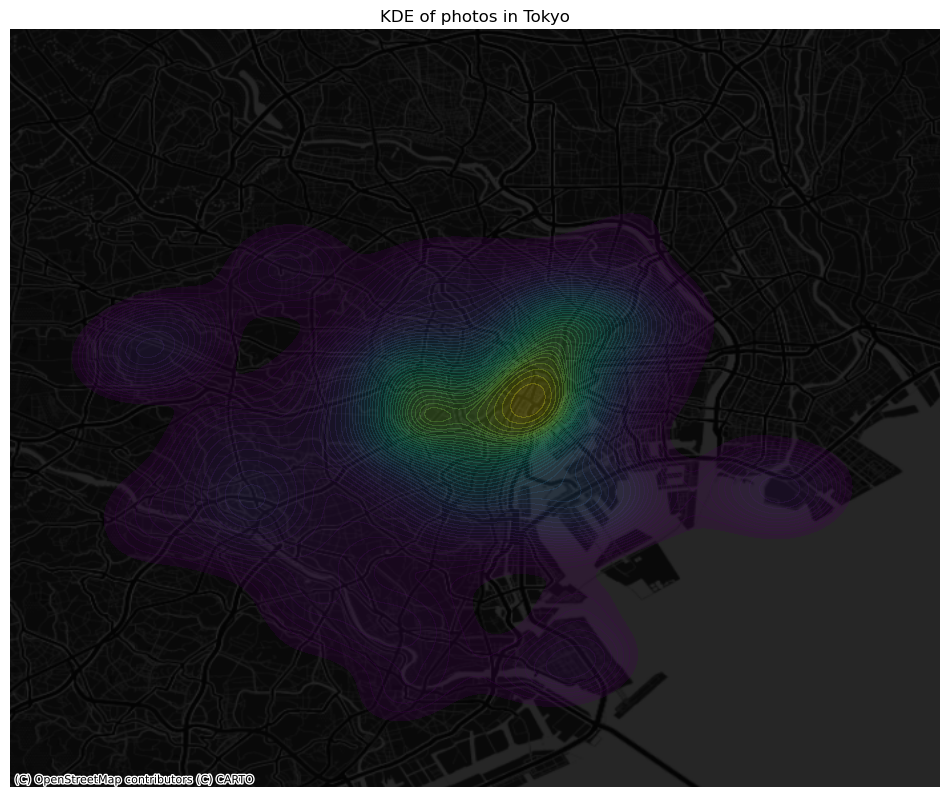

In [25]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(12, 12))
# Add KDE layer that displays probability surface
sns.kdeplot(
    x='longitude', 
    y='latitude', 
    data=tokyo_sub,
    n_levels=50, 
    fill=True,
    alpha=0.25,
    cmap="viridis"
)
# Remove axis
ax.set_axis_off()
# Add basemap
cx.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatterNoLabels
)
# Add title of the map
ax.set_title("KDE of photos in Tokyo")
# Draw map
plt.show()

In [26]:
# Set up algorithm
algo = DBSCAN(eps=100, min_samples=50)

In [29]:
## Express points in metres
# Convert lon/lat into Point objects + set CRS
pts = gpd.points_from_xy(
    tokyo["longitude"],
    tokyo["latitude"],
    crs="EPSG:4326"
)
# Convert lon/lat points to Japanese CRS in metres
pts = gpd.GeoDataFrame({"geometry": pts}).to_crs(epsg=2459)
# Extract coordinates from point objects into columns
tokyo["X_metres"] = pts.geometry.x
tokyo["Y_metres"] = pts.geometry.y

In [31]:
algo.fit(tokyo[["X_metres", "Y_metres"]])

DBSCAN(eps=100, min_samples=50)

In [32]:
algo.labels_

array([-1, -1, -1, ...,  8, -1, -1])

In [33]:
# Print only the first five values
algo.core_sample_indices_[:5]

array([12, 25, 28, 46, 63])

In [34]:
lbls = pd.Series(algo.labels_, index=tokyo.index)

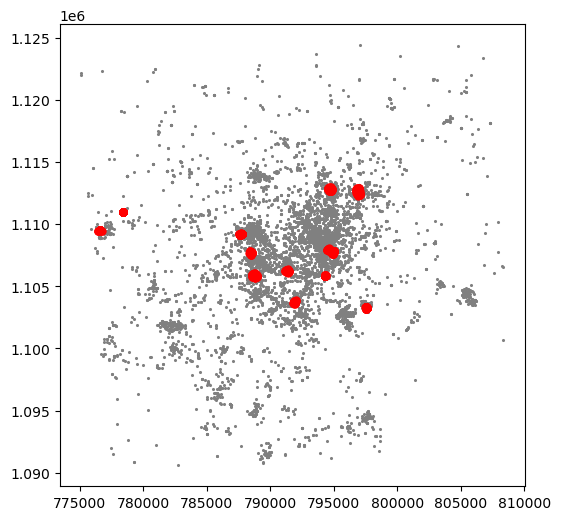

In [35]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Assign labels to tokyo table dynamically and
# subset points that are not part of any cluster (noise)
noise = tokyo.assign(
    lbls=lbls
).query("lbls == -1")
# Plot noise in grey
ax.scatter(
    noise["X_metres"], 
    noise["Y_metres"], 
    c='grey', 
    s=5, 
    linewidth=0
)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(
    tokyo.loc[tokyo.index.difference(noise.index), "X_metres"], 
    tokyo.loc[tokyo.index.difference(noise.index), "Y_metres"],
    c="red", 
    linewidth=0
)
# Display the figure
plt.show()

In [36]:
# Set up algorithm
algo = DBSCAN(eps=500, min_samples=10)
# Fit to Tokyo projected points
algo.fit(tokyo[["X_metres", "Y_metres"]])
# Store labels
lbls = pd.Series(algo.labels_, index=tokyo.index)

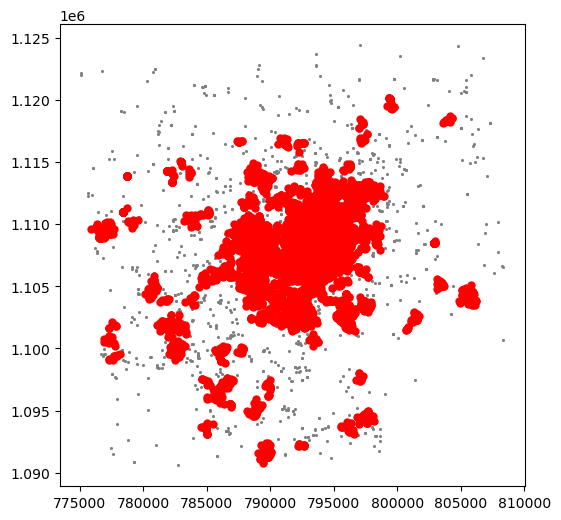

In [37]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Assign labels to tokyo table dynamically and
# subset points that are not part of any cluster (noise)
noise = tokyo.assign(
    lbls=lbls
).query("lbls == -1")
# Plot noise in grey
ax.scatter(
    noise["X_metres"], 
    noise["Y_metres"], 
    c='grey', 
    s=5, 
    linewidth=0
)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(
    tokyo.loc[tokyo.index.difference(noise.index), "X_metres"], 
    tokyo.loc[tokyo.index.difference(noise.index), "Y_metres"],
    c="red", 
    linewidth=0
)
# Display the figure
plt.show()

In [38]:
def clusters(db, eps, min_samples):
    '''
    Compute and visualize DBSCAN clusters    
    ...
    
    Arguments
    ---------
    db          : (Geo)DataFrame
                  Table with at least columns `X` and `Y` for point coordinates
    eps         : float
                  Maximum radious to search for points within a cluster
    min_samples : int
                  Minimum number of points in a cluster
    '''
    algo = DBSCAN(eps=eps, min_samples=min_samples)
    algo.fit(db[['X_metres', 'Y_metres']])
    lbls = pd.Series(algo.labels_, index=db.index)

    f, ax = plt.subplots(1, figsize=(6, 6))
    noise = db.loc[lbls==-1, ['X_metres', 'Y_metres']]
    ax.scatter(noise['X_metres'], noise['Y_metres'], c='grey', s=5, linewidth=0)
    ax.scatter(
        db.loc[db.index.difference(noise.index), 'X_metres'],
        db.loc[db.index.difference(noise.index), 'Y_metres'],
        c='red', 
        linewidth=0
    )
    return plt.show()

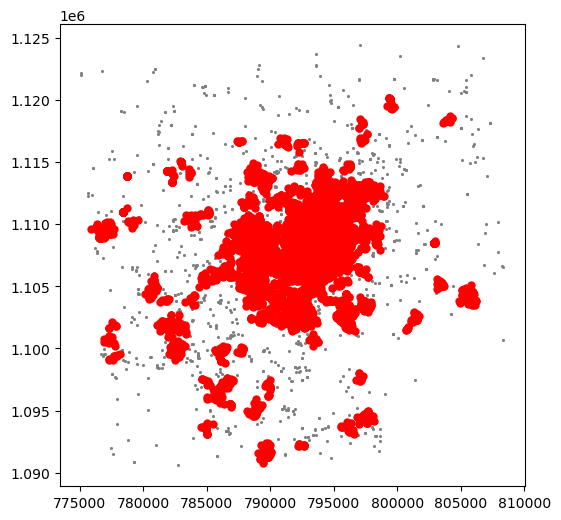

In [39]:
clusters(tokyo, 500, 10)

In [40]:
interact(
    clusters,                 # Method to make interactive
    db=fixed(tokyo),          # Data to pass on db (does not change)
    eps=(50, 500, 50),        # Range start/end/step of eps
    min_samples=(50, 300, 50) # Range start/end/step of min_samples
);

interactive(children=(IntSlider(value=250, description='eps', max=500, min=50, step=50), IntSlider(value=150, …

21